In [1]:
import numpy as np
import pandas as pd
np.random.seed(123)

# viz
import matplotlib.pyplot as plt

# notebook settings
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_columns', 1000)

## Sample Prep

In [2]:
samples = pd.read_csv('../data/TCGA/rna-seq_pan/meta/gdc_sample_sheet.2019-12-12.tsv', sep="\t")
# get file type
samples['data'] = [val[1] for i,val in samples['File Name'].str.split(".").items()]
samples['project'] = [val[1] for i,val in samples['Project ID'].str.split("-").items()]
samples['project'].value_counts()

BRCA    1206
LUAD     588
UCEC     567
KIRC     554
LUSC     543
LGG      524
PRAD     517
COAD     506
THCA     505
SKCM     469
BLCA     431
LIHC     421
STAD     402
OV       379
KIRP     308
CESC     306
ESCA     171
PAAD     171
GBM      166
TGCT     150
PCPG     133
LAML     123
KICH      81
ACC       75
CHOL      41
SARC      10
DLBC       9
READ       7
MESO       1
Name: project, dtype: int64

In [3]:
samples.shape
cases = samples[samples['Sample Type']=='Primary Tumor'].sample(frac=1).copy()
cases.shape
proj = cases['project'].value_counts().head(10).index
cases = cases[cases['project'].isin(proj)]
cases['project'].value_counts()
cases.shape

(9364, 10)

(8166, 10)

BRCA    1087
UCEC     544
LUAD     528
LGG      506
LUSC     496
KIRC     483
PRAD     466
COAD     465
THCA     445
BLCA     412
Name: project, dtype: int64

(5432, 10)

## Dataset Prep

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

target = 'project'
cases[target] = cases[target].astype('category')

train, test = train_test_split(cases)
train[target].value_counts()
test[target].value_counts()

BRCA    810
UCEC    418
LUAD    393
LGG     375
LUSC    374
KIRC    358
PRAD    347
COAD    346
THCA    343
BLCA    310
Name: project, dtype: int64

BRCA    277
LUAD    135
LGG     131
UCEC    126
KIRC    125
LUSC    122
PRAD    119
COAD    119
THCA    102
BLCA    102
Name: project, dtype: int64

In [5]:
import torch
from torch.optim import lr_scheduler
import torch.optim as optim
from torch.autograd import Variable
torch.manual_seed(123)

from trainer import fit
import visualization as vis
import numpy as np
cuda = torch.cuda.is_available()
print("Cuda is available: {}".format(cuda))

classes = {key:val for val,key in enumerate(train[target].cat.categories.values)}
classes

Cuda is available: True


{'BLCA': 0,
 'BRCA': 1,
 'COAD': 2,
 'KIRC': 3,
 'LGG': 4,
 'LUAD': 5,
 'LUSC': 6,
 'PRAD': 7,
 'THCA': 8,
 'UCEC': 9}

In [6]:
from tcga_datasets import TCGA, SiameseTCGA
root_dir = "../data/TCGA/rna-seq_pan/"
batch_size = 1

train_dataset = TCGA(root_dir, samples=train, train=True, target=target, norm=False)
test_dataset = TCGA(root_dir, samples=test, train=False, target=target, norm=False)

scaler = StandardScaler()
train_dataset.data = pd.DataFrame(scaler.fit_transform(train_dataset.data),
                                  index=train_dataset.data.index,
                                  columns=train_dataset.data.columns)
test_dataset.data = pd.DataFrame(scaler.transform(test_dataset.data),
                                 index=test_dataset.data.index,
                                 columns=test_dataset.data.columns)

kwargs = {'num_workers': 10, 'pin_memory': True} if cuda else {'num_workers': 10}
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

## Siamese Network - Online Pair Selection

In [7]:
from datasets import BalancedBatchSampler

# We'll create mini batches by sampling labels that will be present in the mini batch and number of examples from each class
train_batch_sampler = BalancedBatchSampler(train_dataset.labels, n_classes=2, n_samples=8)
test_batch_sampler = BalancedBatchSampler(test_dataset.labels, n_classes=2, n_samples=8)

kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
online_train_loader = torch.utils.data.DataLoader(train_dataset, batch_sampler=train_batch_sampler, **kwargs)
online_test_loader = torch.utils.data.DataLoader(test_dataset, batch_sampler=test_batch_sampler, **kwargs)

# Set up the network and training parameters
from tcga_networks import EmbeddingNet
from losses import OnlineContrastiveLoss
from utils import AllPositivePairSelector, HardNegativePairSelector # Strategies for selecting pairs within a minibatch

margin = 1.
embedding_net = EmbeddingNet()
model = embedding_net
if cuda:
    model.cuda()
loss_fn = OnlineContrastiveLoss(margin, HardNegativePairSelector())
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 50

EmbeddingNet(
  (fc): Sequential(
    (linear1): Linear(in_features=60483, out_features=2000, bias=True)
    (relu1): PReLU(num_parameters=1)
    (linear2): Linear(in_features=2000, out_features=500, bias=True)
    (relu2): PReLU(num_parameters=1)
    (linear3): Linear(in_features=500, out_features=250, bias=True)
    (relu3): PReLU(num_parameters=1)
    (linear4): Linear(in_features=250, out_features=100, bias=True)
    (relu4): PReLU(num_parameters=1)
    (linear5): Linear(in_features=100, out_features=50, bias=True)
    (relu5): PReLU(num_parameters=1)
    (linear6): Linear(in_features=50, out_features=10, bias=True)
    (relu6): PReLU(num_parameters=1)
    (linear7): Linear(in_features=10, out_features=2, bias=True)
  )
)

In [8]:
train_loss, val_loss = fit(online_train_loader, online_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval)

Train: [0/4074 (0%)]	Loss: 0.497974
Train: [800/4074 (20%)]	Loss: 16.043582
Train: [1600/4074 (39%)]	Loss: 48.414517
Train: [2400/4074 (59%)]	Loss: 8.684212
Train: [3200/4074 (79%)]	Loss: 0.339499
Train: [4000/4074 (98%)]	Loss: 0.198338
Epoch: 1/20. Train set: Average loss: 14.5064
Epoch: 1/20. Validation set: Average loss: 0.3346
Train: [0/4074 (0%)]	Loss: 0.202315
Train: [800/4074 (20%)]	Loss: 0.380755
Train: [1600/4074 (39%)]	Loss: 0.741181
Train: [2400/4074 (59%)]	Loss: 1.764164
Train: [3200/4074 (79%)]	Loss: 0.231615
Train: [4000/4074 (98%)]	Loss: 50.400194
Epoch: 2/20. Train set: Average loss: 11.0701
Epoch: 2/20. Validation set: Average loss: 7737.9861
Train: [0/4074 (0%)]	Loss: 74.757805
Train: [800/4074 (20%)]	Loss: 2992.300978
Train: [1600/4074 (39%)]	Loss: 191846.509268
Train: [2400/4074 (59%)]	Loss: 90301.190446
Train: [3200/4074 (79%)]	Loss: 39874.674219
Train: [4000/4074 (98%)]	Loss: 197.000392
Epoch: 3/20. Train set: Average loss: 64018.7298
Epoch: 3/20. Validation set: 

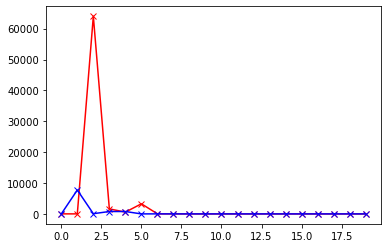

In [9]:
plt.plot(range(0, n_epochs), train_loss, 'rx-')
plt.plot(range(0, n_epochs), val_loss, 'bx-')

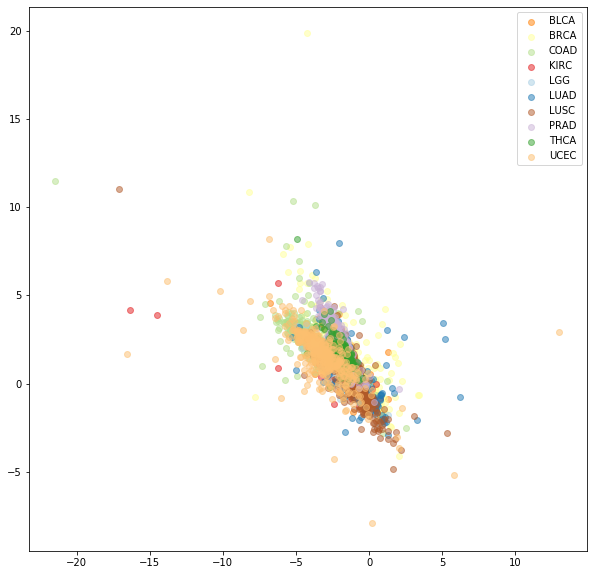

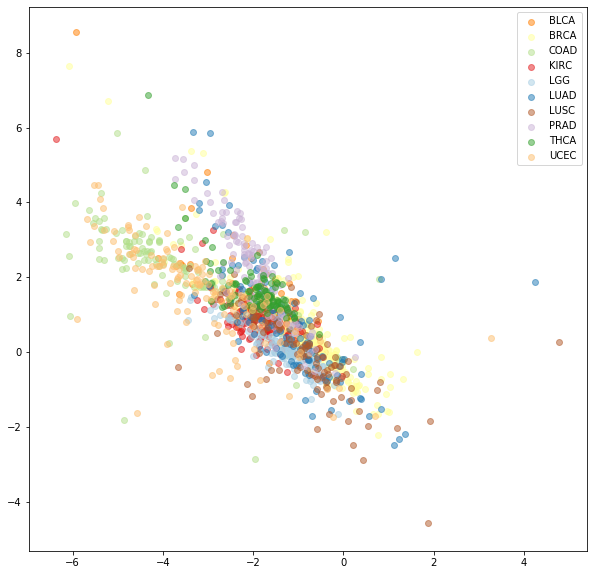

In [10]:
train_embeddings_ocl, train_labels_ocl = vis.extract_embeddings(train_loader, model)
vis.plot_embeddings(train_embeddings_ocl, train_labels_ocl, train_dataset.labels_dict)
val_embeddings_ocl, val_labels_ocl = vis.extract_embeddings(test_loader, model)
vis.plot_embeddings(val_embeddings_ocl, val_labels_ocl, test_dataset.labels_dict)

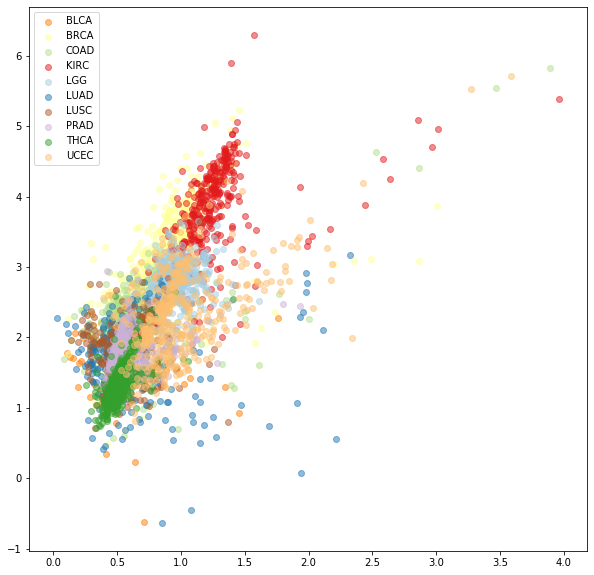

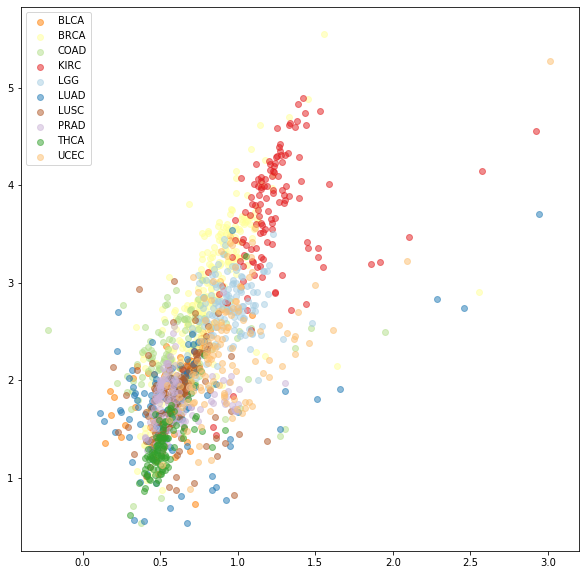

In [22]:
train_embeddings_ocl, train_labels_ocl = vis.extract_embeddings(train_loader, model)
inliers = np.where(train_embeddings_ocl[:,0] < 4)
vis.plot_embeddings(train_embeddings_ocl[inliers], train_labels_ocl[inliers], train_dataset.labels_dict)
val_embeddings_ocl, val_labels_ocl = vis.extract_embeddings(test_loader, model)
inliers = np.where(val_embeddings_ocl[:,0] < 4)
vis.plot_embeddings(val_embeddings_ocl[inliers], val_labels_ocl[inliers], test_dataset.labels_dict)